In [1]:
import pandas as pd
import geopandas as gpd
from datetime import date, datetime, timedelta
from influxdb_client import InfluxDBClient, Point, WritePrecision, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
import json
from shapely.geometry import box, mapping
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata
from functools import partial
from pathlib import Path
import boto3
from pprint import pprint
from pathlib import Path
from dotenv import load_dotenv
import os

# Avoid unnecessary warning about pivot function (not applicable to format)
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.simplefilter("ignore", MissingPivotFunction)

load_dotenv()

True

In [42]:
##### Get WSE source data using InfluxDB client, return as pandas dataframe
# Set some default time variables for reference
start_time = '2021-05-24 00:00:00' # Modifiable
start_day = pd.Timestamp(start_time).strftime('%Y-%m-%d')
today = date.today()
yesterday = today - timedelta(days = 1)
now = datetime.now()
#end_time = end_day = yesterday.strftime('%Y-%m-%d')
end_time = end_day = '2021-09-01'

# Do not modify these settings
token = "ZmsU7WoVdvs45GVB2jNeBzDwJFjza4ZfkQple4FaRqHq8sjxDPnP5kVWOFnVygjbQPY1H_SUcXCU4xX-rn692Q=="
org = "TWI"
bucket = "riverGagesSubset"
client=InfluxDBClient(url="http://10.3.10.19:8086", token=token, org=org,debug=False,enable_gzip=True)
query_api = client.query_api()

# WSE values aggregated over 3h period beginning 00:00z, output references the end of each period  
# e.g. '2022-09-01 03:00:00+00:00' represents mean values for selected date between 00:00z and 03:00z
query = f'''from(bucket: "riverGagesSubset")
|> range(start: {start_day}T00:00:00Z, stop: {end_day}T23:59:00Z)
|> filter(fn: (r) => r["_measurement"] == "Stage_Ft")
|> aggregateWindow(every: 3h, fn: mean, createEmpty: false)
|> group()'''

# Import into df, drop and rename columns. 
wse_df = query_api.query_data_frame(org=org, query=query)
wse_df = wse_df.drop(columns=["_start","result","table","_field","_stop","_measurement"])
wse_df = wse_df.rename(columns={"_value": "z", "_time": "time", "Longitude": "lon_g", "Latitude": "lat_g", "Station": "sid", "river_mile": "mile"})

# Modify selected field dtypes to simplify downstream operations
wse_df[['mile', 'lat_g', 'lon_g']] = wse_df[['mile', 'lat_g', 'lon_g']].apply(pd.to_numeric)
wse_df['time'] = pd.to_datetime(wse_df['time'],utc=True)


In [21]:
# Use the time field of the queried data to build a list to iterate the wse interpolation from
wse_period_range = wse_df['time'].values.tolist()

# Convert POSIX time to datetime then string
def format_time(time):
    format = pd.to_datetime(time)
    return format.strftime('%Y-%m-%d %H:%M:%S')

wse_period_list = list((map(lambda t: format_time(t), wse_period_range)))


In [22]:
# Function to interpolate missing WSE at predetermined RM
def wse_interp(time_query):
        
    # Pass period selection to create subset dataframe 
    period_select = str(time_query)
    wse_slice_df = wse_df.loc[wse_df['time'] == period_select]
    
    # Remove gage at Cape Giradeau to fix conflict with river mile join
    bad_gage = 'rg_CE401278'
    wse_slice_df = wse_slice_df.loc[wse_slice_df['sid'] != bad_gage]
    
    # Import river mile .geojson into gdf and drop matching columns to simplify following join
    url = 'https://raw.githubusercontent.com/hbienn/smartport_wse/main/'
    rm_formatted = f'{url}/mr_rm.geojson'
    rm_gdf = gpd.read_file(rm_formatted, crs='epsg:4326')
    rm_gdf = rm_gdf.drop(columns=['OBJECTID', 'ord', 'sid', 'wse', 'time', 'lat_g', 'lon_g'])
    
    # Round river mile to 1 decimal place to account for any floating precision errors
    rm_gdf = rm_gdf.round({'mile':1})
    rm_gdf = rm_gdf.sort_values('mile')
    rm_gdf = rm_gdf.reindex()
    
    # Merge WSE df with river mile gdf using mile as key
    wse_gdf = rm_gdf.merge(wse_slice_df, how='outer', on='mile')
    
    # Reorder columns for obsessive compulsive reasons
    cols = wse_gdf.columns.tolist()
    cols = ['mile', 'sid', 'z', 'time','lon', 'lat', 'lat_g', 'lon_g', 'geometry']
    wse_gdf = wse_gdf[cols]
    wse_gdf = wse_gdf.sort_values('mile')
    
    # Add column for period and calculate it as max of ['time'] and convert to integer. 
    # Establishes a time dimension for each point that is persistent through the downstream interpolation.
    period = pd.to_datetime(time_query)
    year = period.strftime("%Y")
    day_of_year = period.strftime("%j")
    period = int(round(period.timestamp())*1000000000)
    wse_gdf.insert(4,'period', period)
    
    # Subset gdf to limit spatial domain to south of RM 1000 in the vicinity of Cape Giradeau, MO
    wse_gdf = wse_gdf.loc[wse_gdf['mile'] <= 1000]
    
    # Interpolates missing WSE values based on a linear relationship between river mile and known WSE values.
    wse_gdf = wse_gdf.dissolve(by='mile', aggfunc='mean')
    wse_gdf = wse_gdf.sort_values('mile')
    wse_gdf['z'] = wse_gdf['z'].interpolate(method='linear', limit_direction = 'both')
    
    # User modified variables
    bounding_box = json.dumps(mapping(box(-92,28.5,-89,31.5))) # Not implemented 
    projection = 'EPSG:26915'
    resolution = r = 500
    
    # Still issues here with getting make_geocube to recognize time field and assign it correct dtype (datetime64[ns]). 
    # Potentially results from use of a timezone-aware dtype, workaround implemented.
    wse_xr = make_geocube(
                        vector_data = wse_gdf,
                        measurements = ['z',],
                        #datetime_measurements=['period'],
                        output_crs = projection,
                        resolution = (r, r),
                        #geom = bounding_box,
                        #interpolate_na_method='linear'
                        rasterize_function=partial(rasterize_points_griddata, method='linear', filter_nan = True)
                        )
    # Expand dimensions and populate with the POSIX time value variable previously assigned 
    period = int(wse_gdf['period'].mean())
    wse_xr = wse_xr.expand_dims('time')
    arr = wse_xr['time'].to_numpy()
    arr[0,] = period
    wse_xr['time'] = arr
    wse_xr['time'] = pd.to_datetime(wse_xr['time'],utc=True)

    # Clip surface to extent of Mississippi River
    url = 'https://raw.githubusercontent.com/hbienn/smartport_wse/main/'
    mr_formatted = f'{url}/generalized_nhdarea_stlouistogulf_utm.geojson'
    mr = gpd.read_file(mr_formatted, crs=projection)
    wse_xr = wse_xr.rio.clip(mr.geometry, mr.crs, drop=True, invert=False)
    
    # Export as .netcdf 
    object_name = f'wse_{resolution}m_{period}_y{year}_d{day_of_year}.nc'
    out_path='Z:/wse/'
    file_for_upload = out_path + object_name
    wse_xr.to_netcdf(file_for_upload)
    
    '''
    # Stage for upload to S3
    bucket_name = 'smartport-storage'
    bucket_directory = 'wse/pipeline_test/'
    object_key = bucket_directory + object_name
    s3 = boto3.resource('s3')
    s3.meta.client.upload_file(file_for_upload, bucket_name, object_key)

    # Delete staged .netcdf
    os.remove(file_for_upload)
    '''
    return


In [ ]:
for t in wse_period_list:
    wse_interp(t)

In [33]:
import xarray as xr
import netCDF4
import h5netcdf
import numpy as np
%matplotlib inline

In [40]:
ds = xr.open_dataset(r'Z:\wse\wse_500m_1621911600000000000_y2021_d145.nc')
ds

<xarray.Dataset>
Dimensions:      (y: 1848, x: 474, time: 1)
Coordinates:
  * y            (y) float64 3.205e+06 3.205e+06 ... 4.128e+06 4.128e+06
  * x            (x) float64 6.278e+05 6.282e+05 ... 8.638e+05 8.642e+05
  * time         (time) int64 1621911600000000000
Data variables:
    spatial_ref  int32 ...
    z            (time, y, x) float64 ...

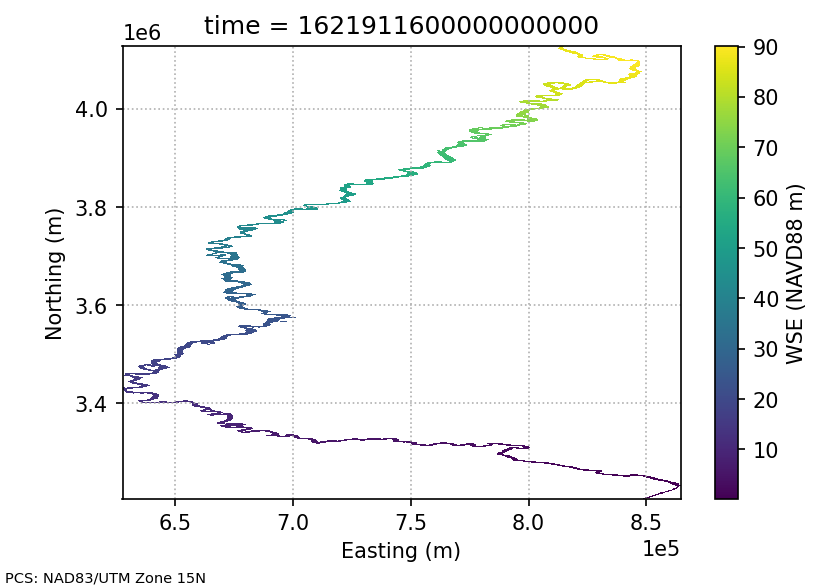

In [41]:
plot = ds.z.where(ds.z!=ds.z.rio.nodata).plot()
plot.axes.set_xlabel('Easting (m)')
plot.axes.set_ylabel('Northing (m)')
#plot.axes.set_title(str(pd.to_datetime(period)))
plot.axes.grid(True, linestyle='dotted')
plot.axes.tick_params()
plot.axes.ticklabel_format(axis = 'both', style='sci', scilimits=(0,0))
plot.colorbar.set_label('WSE (NAVD88 m)')
plot.axes.annotate('PCS: NAD83/UTM Zone 15N', xy=(5,5), xycoords='figure pixels',fontsize=7 )
plot.figure.set_dpi(150) # 300 is best for export
#plot.figure.savefig("Z:/Documents/ArcGIS/Projects/Smartport/smartport_wse_utm15n_160m_br2gom.jpg", transparent=False,)